## Generating finalized neut curves
This notebook generates finalized plots for all serum validation neuts (Figure S7), and neut curves for sera 3944 and 197C (Figure 1D-E). We also generate a dataframe of fold-change ICXX from the WT curve on each run, for analyzing correlation between DMS escape scores and neut assay results.

For detailed analysis of each independent neutralization assay experiment, see `validation_neut_curves_tests.ipynb`

In [1]:
import pandas as pd

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Get neut data from relevant runs for each serum
See `validation_neut_curves_tests.ipynb` for analysis of all runs, and justification for these selections.

In [2]:
# make dict mapping serum to run:
serum_neuts = {
    '2365': ['230909_neuts_tidy'],
    '3857': ['231018_neuts-tidy', '231023_neuts_tidy'],
    '3856': ['231021_3856-4584_tidy'],
    '4584': ['231021_3856-4584_tidy'],
    '3944': ['231027_neuts-tidy'],
    '197C': ['231031_neuts_tidy'], 
    '74C': ['231031_neuts_tidy'], 
}

# get data from relevant dfs for each serum
df_list = []
for serum in serum_neuts:
    i=0
    for filename in serum_neuts[serum]:
        df = pd.read_csv(f'neut_data/{filename}.csv')
        df['serum'] = df['serum'].astype(str)
        df = df[df['serum'] == serum]
        
        if i>0:
            df['serum'] = serum + '_2'
        
        # drop lowest conc for 3944 run
        if serum == '3944':
            df = df[df['concentration'] > 1e-5]
        
        # drop S145H for 2365 run, and rename WT
        if serum == '2365':
            virus_dict = {
                'HK19_wt': 'WT',
            }
            
            df = df.replace({'virus': virus_dict})
            df = df[df['virus'] != 'S145K']
        
        df_list.append(df)
        
        i+=1

# get full df and drop S124R - fluorescence was significantly different
# from all other variants in MOI tests, which skewed data on all runs
full_neut_df = pd.concat(df_list)
full_neut_df = full_neut_df[full_neut_df['virus'] != 'S124R']

### Plot finalized neut curves
Generate a plot of neuts for all sera, and neuts for 3944 and 197C alone (shown in Figure 1).

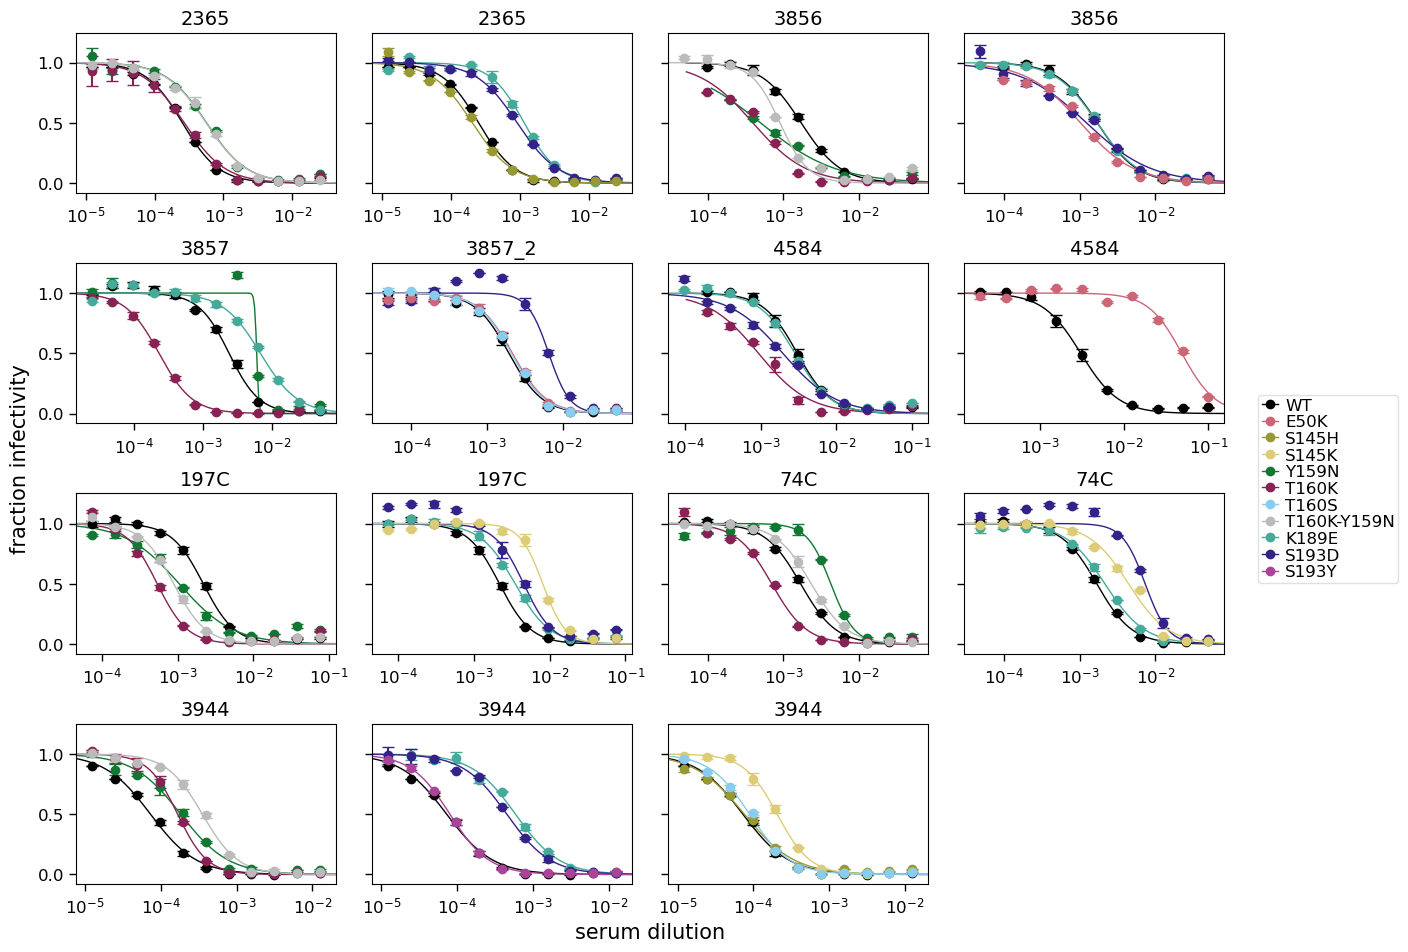

In [3]:
# order viruses for plotting
virus_order = ['WT', 'Y159N', 'T160K', 'T160K-Y159N', 'K189E', 'S193D', 'S193Y', 'E50K', 'S145H', 'S145K', 'T160S']

full_neut_df['virus'] = pd.Categorical(full_neut_df.virus, categories=virus_order, ordered=True)
full_neut_df.sort_values('virus')

full_neut_df = full_neut_df.set_index('virus').loc[virus_order].reset_index()

# order sera for plotting
serum_order = ['2365','3856', '3857', '3857_2', '4584', '197C', '74C', '3944']

full_neut_df['serum'] = pd.Categorical(full_neut_df.serum, categories=serum_order, ordered=True)
full_neut_df.sort_values('serum')

full_neut_df = full_neut_df.set_index('serum').loc[serum_order].reset_index()

# set custom colorscheme
virus_colors = {
    'WT': ['black', 'o'],
    'E50K': ['#CC6677', 'o'],
    'S145H': ['#999933', 'o'],
    'S145K': ['#DDCC77', 'o'],
    'Y159N': ['#117733', 'o'],
    'T160K': ['#882255', 'o'],
    'T160S': ['#88CCEE', 'o'],
    'T160K-Y159N': ['#BBBBBB', 'o'],
    'K189E': ['#44AA99', 'o'],
    'S193D': ['#332288', 'o'],
    'S193Y': ['#AA4499','o'],
}

# fit with neutcurve package
fits = neutcurve.CurveFits(full_neut_df)

fig, axes = fits.plotSera(xlabel='serum dilution',
                          max_viruses_per_subplot=4,
                          sharex=False,
                          virus_to_color_marker=virus_colors
                         )

bbox = matplotlib.transforms.Bbox([[0, 0], [13, 10]])
plt.savefig('finalized_neut_curves.pdf', bbox_inches=bbox)

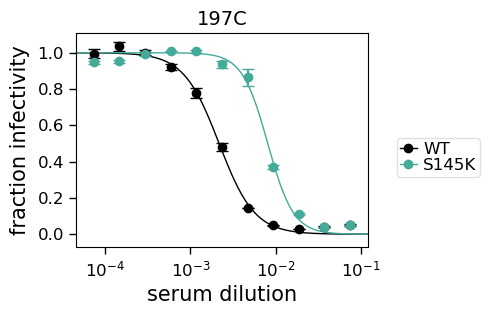

In [26]:
fig1_df = full_neut_df[full_neut_df['serum'].isin(['197C'])]
fig1_df = fig1_df[fig1_df['virus'].isin(
    ['WT', 'S145K', ]
     # 'T160K', 'S145H', 'Y159N', 'T160S', 'K189E', 'S193D']
)]


# # set custom colorscheme
# virus_colors = {
#     'WT': ['black', 'o'],
#     'S145K': ['#0077BB', 'o'],
#     'Y159N': ['#CC3311', 'o'],
#     'T160K': ['#EE7733', 'o'],
#     'K189E': ['#009988', 'o'],
#     'S193D': ['#33BBEE', 'o'],
# }


# set custom colorscheme
virus_colors = {
    'WT': ['black', 'o'],
    'S145K': ['#44AA99', 'o'],
    'Y159N': ['#CC6677', 'o'],
    'T160K': ['#882255', 'o'],
    'K189E': ['#88CCEE', 'o'],
    'S193D': ['#332288', 'o'],
}


# # set custom colorscheme
# virus_colors = {
#     'WT': ['black', 'o'],
#     'E50K': ['#CC6677', 'o'],
#     'S145H': ['#999933', 'o'],
#     'S145K': ['#DDCC77', 'o'],
#     'Y159N': ['#117733', 'o'],
#     'T160K': ['#882255', 'o'],
#     'T160S': ['#88CCEE', 'o'],
#     'T160K-Y159N': ['#BBBBBB', 'o'],
#     'K189E': ['#44AA99', 'o'],
#     'S193D': ['#332288', 'o'],
#     'S193Y': ['#AA4499','o'],
# }

# fit with neutcurve package
fits_fig1 = neutcurve.CurveFits(fig1_df)

fig, axes = fits_fig1.plotSera(xlabel='serum dilution',
                          max_viruses_per_subplot=8,
                          sharex=False,
                          ncol=1,
                          virus_to_color_marker=virus_colors
                         )    

bbox = matplotlib.transforms.Bbox([[0, 0], [5, 3.5]])
plt.savefig('talk_curves_197C_S145K_scheme2.pdf', bbox_inches=bbox)

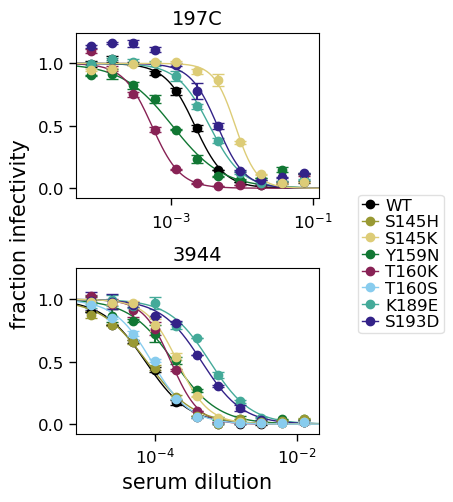

In [4]:
fig1_df = full_neut_df[full_neut_df['serum'].isin(['3944', '197C'])]
fig1_df = fig1_df[fig1_df['virus'].isin(
    ['WT', 'S145K', 'S145H', 'Y159N', 'T160K', 'T160S', 'K189E', 'S193D']
)]

# fit with neutcurve package
fits_fig1 = neutcurve.CurveFits(fig1_df)

fig, axes = fits_fig1.plotSera(xlabel='serum dilution',
                          max_viruses_per_subplot=8,
                          sharex=False,
                          ncol=1,
                          virus_to_color_marker=virus_colors
                         )    

bbox = matplotlib.transforms.Bbox([[0, 0], [5, 6]])
plt.savefig('fig1_curves_197C-3944.pdf', bbox_inches=bbox)

### Calculate fold-change in ICXX for analysis of DMS correlations

In [5]:
def get_fold_changes(fits, ic):
    ic_df = fits.fitParams(ics=[ic])

    # Initialize an empty DataFrame to store the results
    fold_changes = pd.DataFrame()

    # Iterate through unique serum names
    for serum_name in ic_df['serum'].unique():
        # Filter data for the current serum
        serum_data = ic_df[ic_df['serum'] == serum_name]

        # Find the 'WT' ICX value for the current serum
        wt_ic = serum_data[serum_data['virus'] == 'WT'][f'ic{ic}'].values[0]

        # Filter out the 'WT' rows for the current serum
        # variant_data = serum_data[serum_data['virus'] != 'WT'].copy()
        variant_data = serum_data[serum_data['virus'] != 'WT'].copy()

        # Calculate log2 fold changes for the current serum
        variant_data[f'log2_fold_change_ic{ic}'] = np.log2(variant_data[f'ic{ic}'] / wt_ic)

        # Append the results to the fold_changes DataFrame
        fold_changes = pd.concat([fold_changes, variant_data[['serum', 'virus', f'log2_fold_change_ic{ic}', ]]])

    # Reset the index of the final DataFrame
    fold_changes = fold_changes.reset_index(drop=True)

    # Rename the 'virus' column to 'variant'
    fold_changes = fold_changes.rename(columns={'virus': 'variant'})
    
    # Remove '_2' from sera with 2 independent runs
    fold_changes['serum'] = fold_changes['serum'].str.replace('_2', '')
    
    return fold_changes

In [6]:
# test IC50, 80, and 90 fold-changes
ics = [50, 80, 90]

for ic in ics:
    fold_changes = get_fold_changes(fits, ic)
    
    fold_changes.to_csv(f'ic{ic}_fold_changes.csv', index=False)